In [24]:
import numpy as np
import jax
import jax.numpy as jnp
from jax.example_libraries import stax, optimizers
import matplotlib.pyplot as plt
import pinns 
import datetime
import jax.scipy.optimize
import jax.flatten_util
import scipy
import scipy.optimize

In [25]:
from jax.config import config
config.update("jax_enable_x64", True)
rnd_key = jax.random.PRNGKey(1234)

In [26]:
def create_geometry(key, scale = 1):
    R = 2
    r = 1
    
    knots = np.array([[[r,0],[R,0]],[[r,r],[R,R]],[[0,r],[0,R]]])
    weights = np.ones(knots.shape[:2])
    weights[1,:] = 1/np.sqrt(2)

    basis2 = pinns.bspline.BSplineBasisJAX(np.linspace(-1,1,2),1)
    basis1 = pinns.bspline.BSplineBasisJAX(np.array([-1,1]),2)

    geom = pinns.geometry.PatchNURBSParam([basis1, basis2], knots, weights, 0, 2, key)
    return  geom

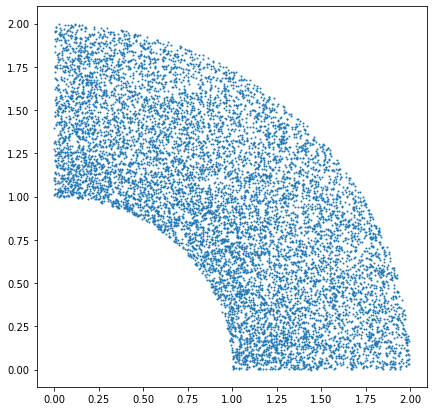

In [27]:
geom = create_geometry(rnd_key)

pts,_ = geom.importance_sampling(10000)

plt.figure(figsize=(7,7))
plt.scatter(pts[:,0], pts[:,1], s = 1)

In [28]:
def interface_function2d(nd, endpositive, endzero, nn):

    faux = lambda x: ((x-endzero)**1/(endpositive-endzero)**1)
    if nd == 0:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

def jump_function2d(nd, pos_y, nn):

    faux = lambda x: jnp.exp(-4.0*jnp.abs(x-pos_y))
    if nd == 1:
        fret = lambda ws, x: (nn(ws, x[...,1][...,None]).flatten()*faux(x[...,0]))[...,None]
    else:
        fret = lambda ws, x: (nn(ws, x[...,0][...,None]).flatten()*faux(x[...,1]))[...,None]
    return fret

# def ExpHat(hidden_size, out_dim, W_init=glorot_normal(), b_init=normal()):
#   """Layer constructor function for a dense (fully-connected) layer."""
#   def init_fun(rng, input_shape):
#     output_shape = input_shape[:-1] + (out_dim,)
#     k1, k2 = random.split(rng)
#     W, b = W_init(k1, (input_shape[-1], out_dim)), b_init(k2, (out_dim,))
#     return output_shape, (W, b)
#   def apply_fun(params, inputs, **kwargs):
#     b, b = params
#     return jnp.dot(inputs, W) + b
#   return init_fun, apply_fun
def ExpHat(x, scale = 0.1):
    return jnp.exp(-jnp.abs(x)/scale)

class Model(pinns.PINN):
    def __init__(self, rand_key):
        super().__init__()
        self.key = rand_key

        nl = 10
        acti =  stax.elementwise(lambda x: jax.nn.leaky_relu(x)**2)

        
        block_first = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl), acti, stax.Dense(nl), acti),stax.Dense(nl)),stax.FanInSum)
        block = stax.serial(stax.FanOut(2),stax.parallel(stax.serial(stax.Dense(nl), acti, stax.Dense(nl), acti),stax.Dense(nl)),stax.FanInSum)
        
        self.add_neural_network('u1',stax.serial(block_first,block,block, block, stax.Dense(2)),(-1,2)) # iron
        
        
        
        self.points = self.get_points_MC(100000, self.key)
        
        E = 0.02e4
        nu = 0.1
        self.E = E
        self.nu = nu
        
        self.lamda = E*nu/(1+nu)/(1-2*nu)
        self.mu = E/2/(1+nu)
        
        rho = 0.2
        g = 9.81
        self.rho = rho
        
        self.f = np.array([0.0,-g*rho])
        
        self.c = self.lamda * np.einsum('ij,kl->ijkl', np.eye(2), np.eye(2)) + self.mu * (np.einsum('ik,jl->ijkl',np.eye(2),np.eye(2)) + np.einsum('il,jk->ijkl',np.eye(2),np.eye(2)))
        
    def get_points_MC(self, N, key):        

        points = {}


        ys = jax.random.uniform(key ,(N,2))*2-1
        Weights = jnp.ones((N,))*4/ys.shape[0]
        # ys = np.array(jax.random.uniform(self.key, (N,2)))*2-1
        # Weights = jnp.ones((N,))*4/ys.shape[0]


        points['ys1'] = ys
        points['ws1'] = Weights
        points['omega1'], points['G1'], points['K1'] = geom.GetMetricTensors(ys)
       


        return points


    def solution1(self, ws, y):
        # iron
        alpha = 2
        u = self.neural_networks['u1'](ws['u1'],y)
        v = ((1-y[...,0]))[...,None]
        
        return u*jnp.concatenate((v,v),-1)



    def loss_pde(self, ws, points):
        jacs = pinns.operators.jacobian(lambda x : self.solution1(ws,x))(points['ys1'])
        J = geom.GetJacobian(points['ys1'])
        
        jacs_x = jnp.einsum('mij,mkj->mik',jacs,points['G1'])
        divs_x = (jacs_x[...,0,0]+jacs_x[...,1,1])[...,None]
        
        strain = 0.5*(jacs_x+jnp.transpose(jacs_x,[0,2,1]))
        
        stress = self.lamda * jnp.einsum('ij,jkl->ikl',divs_x, jnp.eye(2)[None,...]) +2*self.mu*strain
        # D = jnp.eye(4)
        
        # BTDB = jnp.einsum('ji,jk,kl->il',B,D,B)
        
        # a = jnp.dot(jnp.einsum('mi,mij,mj->m',gradsx,BTDB,gradsx), points['ws1']*points['omega1']) 

        a = 0.5*jnp.dot(jnp.einsum('mij,mij->m',stress, strain), points['ws1']*points['omega1']) 
        # a = jnp.dot(jnp.einsum('mij,ijkl,mkl->m',strain,self.c,strain), points['ws1']*points['omega1']) 
        rhs = jnp.dot(jnp.einsum('j,mkj,mk->m',self.f,J,self.solution1(ws,points['ys1'])), points['omega1']*points['ws1'])
        # rhs = jnp.dot(jnp.einsum('i,mij,mj->m',self.f, points['K1'], self.solution1(ws,points['ys1'])), points['ws1'])
        return a-rhs

    def loss(self, ws, pts):
        lpde = self.loss_pde(ws, pts)
        return lpde


In [35]:

rnd_key = jax.random.PRNGKey(1235)
model = Model(rnd_key)
w0 = model.init_unravel()
weights = model.weights 

dev = jax.devices()[1]

# loss_compiled = jax.jit(model.loss_handle, device = jax.devices()[0])
# lossgrad_compiled = jax.jit(model.lossgrad_handle, device = jax.devices()[0])
# 
# def loss_grad(w):
#     l, gr = lossgrad_compiled(jnp.array(w))
#     return np.array( l.to_py() ), np.array( gr.to_py() )

opt_type = 'LBFGS'

if opt_type == 'ADAM':

    batch_size = 5000

    get_compiled = jax.jit(lambda key: model.get_points_MC(batch_size, key), device = dev)
    %time pts = get_compiled(jax.random.PRNGKey(1235))
    %time pts = get_compiled(jax.random.PRNGKey(1111))

    lr_opti = optimizers.piecewise_constant([2000,4000,6000,8000,12000], [0.01, 0.005, 0.001, 0.0005,0.0001,0.00005])
    opt_init, opt_update, get_params = optimizers.adam(lr_opti)

    opt_state = opt_init(weights)

    # get initial parameters
    params = get_params(opt_state)

    loss_grad = jax.jit(lambda ws, pts: (model.loss(ws, pts), jax.grad(model.loss)(ws, pts)), device = dev)

    def step(params, opt_state, key):
        # points = model.get_points_MC(5000)
        points = model.get_points_MC(batch_size, key)
        loss, grads = loss_grad(params, points)
        opt_state = opt_update(0, grads, opt_state)

        params = get_params(opt_state)
        
        return params, opt_state, loss

    step_compiled = jax.jit(step, device = dev)
    step_compiled(params, opt_state, rnd_key)

    n_epochs = 14000

    hist = []

    tme = datetime.datetime.now()
    for k in range(n_epochs):    
        params, opt_state, loss = step_compiled(params, opt_state, jax.random.PRNGKey(np.random.randint(32131233123)))
        
        hist.append(loss)
        
        print('Epoch %d/%d - loss value %e'%(k+1, n_epochs, loss))
    # update params
    model.weights = params
    weights = params
    tme = datetime.datetime.now() - tme
    print('Elapsed time ', tme)
elif opt_type == 'LBFGS':

    points = model.get_points_MC(10000, rnd_key)
    dev = jax.devices()[1]

    lossgrad_compiled = jax.jit(model.lossgrad_handle, device = jax.devices()[0])
    
    def loss_grad(w):
        l, gr = lossgrad_compiled(jnp.array(w), points)
        return np.array( l.to_py() ), np.array( gr.to_py() )

    tme = datetime.datetime.now()
    #results = jax.scipy.optimize.minimize(loss_grad, x0 = weights_vector, method = 'bfgs', options = {'maxiter': 10})
    # result = scipy.optimize.minimize(loss_grad, x0 = w0.to_py(), method = 'BFGS', jac = True, tol = 1e-8, options = {'disp' : True, 'maxiter' : 2000}, callback = None)
    result = scipy.optimize.minimize(loss_grad, x0 = w0.to_py(), method = 'L-BFGS-B', jac = True, tol = 1e-19, options = {'disp' : True, 'maxiter' : 3000, 'iprint': 1})
    tme = datetime.datetime.now() - tme

    weights = model.weights_unravel(jnp.array(result.x))
    model.weights = weights
    print()
    print('Elapsed time', tme)


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =         1182     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.76682D+08    |proj g|=  1.27194D+10

At iterate    1    f=  2.21930D+02    |proj g|=  1.63484D+03

At iterate    2    f=  1.91201D+02    |proj g|=  1.18586D+03

At iterate    3    f=  1.28214D+02    |proj g|=  5.35621D+02

At iterate    4    f=  8.65845D+01    |proj g|=  3.48867D+02

At iterate    5    f=  3.74670D+01    |proj g|=  1.61927D+02

At iterate    6    f=  1.85473D+01    |proj g|=  6.25393D+01

At iterate    7    f=  9.86208D+00    |proj g|=  4.23554D+01

At iterate    8    f=  5.64218D+00    |proj g|=  4.71074D+01

At iterate    9    f=  4.29108D+00    |proj g|=  1.67937D+01

At iterate   10    f=  3.80305D+00    |proj g|=  1.47988D+01

At iterate   11    f=  3.32604D+00    |proj g|=  1.61157D+01

At iterate   12    f=  2.11712D+00    |proj g|=  1.46068D+01

At iterate   13    f=  9.8

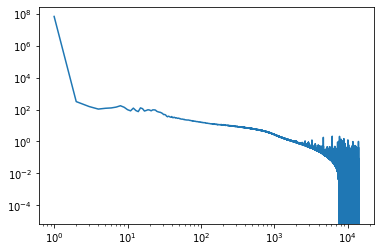

In [36]:
plt.figure()

plt.loglog(np.arange(n_epochs)+1,np.array(hist))

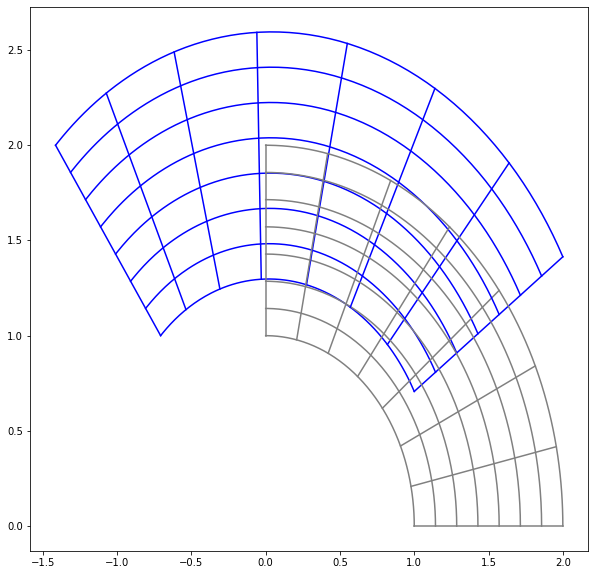

In [45]:
yspace = np.linspace(-1,1,128)
ysteps = np.linspace(-1,1,8)

fh = jax.jit(lambda ys: (geom(ys), geom.GetJacobian(ys), model.solution1(weights, ys)) )

plt.figure(figsize=(10,10))
for y in ysteps:
    ys  = jnp.array(np.concatenate((yspace[...,None],yspace[...,None]*0+y),-1))
    Xs, Js, Us = fh(ys)

    Us = jnp.ones([128,2])*jnp.array([1,0])
    Us = jnp.einsum('mji,mi->mj',Js,Us)
    plt.plot(Xs[:,0],Xs[:,1],'grey')
    plt.plot(Xs[:,0]+Us[:,0],Xs[:,1]+Us[:,1],'blue')
    
    ys = jnp.array(np.concatenate((yspace[...,None]*0+y,yspace[...,None]),-1))
    Xs, Js, Us = fh(ys)

    Us = jnp.ones([128,2])*jnp.array([1,0])
    Us = jnp.einsum('mji,mi->mj',Js,Us)
    plt.plot(Xs[:,0],Xs[:,1],'grey')
    plt.plot(Xs[:,0]+Us[:,0],Xs[:,1]+Us[:,1],'blue')

In [46]:
Js

DeviceArray([[[-7.07106781e-01,  0.00000000e+00],
              [ 0.00000000e+00,  5.00000000e-01]],

             [[-7.12674551e-01,  0.00000000e+00],
              [-5.55111512e-17,  5.00000000e-01]],

             [[-7.18242321e-01,  0.00000000e+00],
              [ 5.55111512e-17,  5.00000000e-01]],

             [[-7.23810091e-01,  0.00000000e+00],
              [ 0.00000000e+00,  5.00000000e-01]],

             [[-7.29377861e-01,  0.00000000e+00],
              [ 0.00000000e+00,  5.00000000e-01]],

             [[-7.34945631e-01,  0.00000000e+00],
              [ 5.55111512e-17,  5.00000000e-01]],

             [[-7.40513401e-01,  0.00000000e+00],
              [ 5.55111512e-17,  5.00000000e-01]],

             [[-7.46081171e-01,  0.00000000e+00],
              [ 5.55111512e-17,  5.00000000e-01]],

             [[-7.51648941e-01,  0.00000000e+00],
              [ 5.55111512e-17,  5.00000000e-01]],

             [[-7.57216711e-01,  0.00000000e+00],
              [ 5.55111512e-17, 

Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.
Building point search tree to accelerate distance queries.
Computed bounding box tree with 17681 nodes for 8841 points.


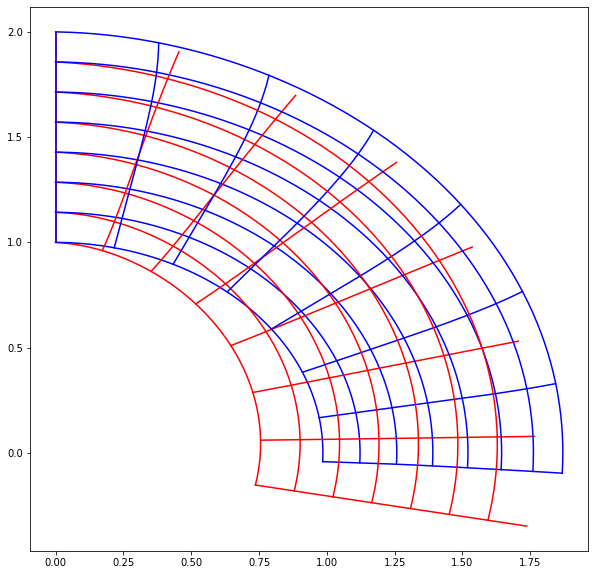

In [38]:
try:
    from elastostatics_2d_fem import FEM

    fem = FEM(model.E, model.nu, model.rho)
    fem.solve(0.025)

    plt.figure(figsize=(10,10))

    for y in ysteps:
        ys  = jnp.array(np.concatenate((yspace[...,None],yspace[...,None]*0+y),-1))
        Xs, Js, Us = fh(ys)
        Us = jnp.einsum('mji,mi->mj',Js,Us)
        Us_fem = fem(np.array(Xs))
        plt.plot(Xs[:,0]+Us_fem[:,0],Xs[:,1]+Us_fem[:,1],'red')
        plt.plot(Xs[:,0]+Us[:,0],Xs[:,1]+Us[:,1],'blue')
        
        ys = jnp.array(np.concatenate((yspace[...,None]*0+y,yspace[...,None]),-1))
        Xs, Js, Us = fh(ys)
        Us = jnp.einsum('mji,mi->mj',Js,Us)
        Us_fem = fem(np.array(Xs))
        plt.plot(Xs[:,0]+Us_fem[:,0],Xs[:,1]+Us_fem[:,1],'red')
        plt.plot(Xs[:,0]+Us[:,0],Xs[:,1]+Us[:,1],'blue')
        
except:
    print("FENICS not available.")
    

In [33]:
print(model.lamda, model.mu)

22.727272727272723 90.9090909090909
